In [1]:
import os
import numpy as np
from glob import glob
from deformation_functions import *
from menpo_functions import *
from logging_functions import *
from data_loading_functions import *
from time import time
from scipy.misc import imsave

%matplotlib inline


In [2]:
dataset='training'
img_dir='/Users/arik/Dropbox/a_mac_thesis/face_heatmap_networks/conventional_landmark_detection_dataset/'
train_crop_dir = 'crop_gt_margin_0.25'
img_dir_ns=os.path.join(img_dir,train_crop_dir+'_ns')
bb_dir = os.path.join(img_dir, 'Bounding_Boxes')
bb_type='gt'
gt = bb_type=='gt'
margin = 0.25
image_size = 256
mode='TRAIN'
augment_basic=True
augment_texture=True
augment_geom=True
bb_dictionary = load_bb_dictionary(bb_dir, mode=mode, test_data=dataset)

In [3]:
def augment_menpo_img_ns(img, img_dir_ns, p_ns=0, ns_ind=None):
    """texture style image augmentation using stylized copies in *img_dir_ns*"""

    img = img.copy()
    if p_ns > 0.5:
        ns_augs = glob(os.path.join(img_dir_ns, img.path.name.split('.')[0] + '*'))
        num_augs = len(ns_augs)
        if num_augs > 0:
            if ns_ind is None or ns_ind >= num_augs:
                ns_ind = np.random.randint(0, num_augs)
            ns_aug = mio.import_image(ns_augs[ns_ind])
            ns_pixels = ns_aug.pixels
            img.pixels = ns_pixels
    return img

def augment_menpo_img_ns_dont_apply(img, img_dir_ns, p_ns=0, ns_ind=None):
    """texture style image augmentation using stylized copies in *img_dir_ns*"""

    img = img.copy()
    if p_ns > 0.5:
        ns_augs = glob(os.path.join(img_dir_ns, img.path.name.split('.')[0] + '*'))
        num_augs = len(ns_augs)
        if num_augs > 0:
            if ns_ind is None or ns_ind >= num_augs:
                ns_ind = np.random.randint(0, num_augs)
            ns_aug = mio.import_image(ns_augs[ns_ind])
            ns_pixels = ns_aug.pixels
    return img

def augment_menpo_img_geom_dont_apply(img, p_geom=0):
    """geometric style image augmentation using random face deformations"""

    img = img.copy()
    if p_geom > 0.5:
        lms_geom_warp = deform_face_geometric_style(img.landmarks['PTS'].points.copy(), p_scale=p_geom, p_shift=p_geom)
    return img

def load_menpo_image_list(
        img_dir, train_crop_dir, img_dir_ns, mode, bb_dictionary=None, image_size=256, margin=0.25,
        bb_type='gt', test_data='full', augment_basic=True, augment_texture=False, p_texture=0,
        augment_geom=False, p_geom=0, verbose=False,ns_ind=None):

    def crop_to_face_image_gt(img):
        return crop_to_face_image(img, bb_dictionary, gt=True, margin=margin, image_size=image_size)

    def crop_to_face_image_init(img):
        return crop_to_face_image(img, bb_dictionary, gt=False, margin=margin, image_size=image_size)

    def augment_menpo_img_ns_rand(img):
        return augment_menpo_img_ns(img, img_dir_ns, p_ns=1. * (np.random.rand() < p_texture),ns_ind=ns_ind)

    def augment_menpo_img_geom_rand(img):
        return augment_menpo_img_geom(img, p_geom=1. * (np.random.rand() < p_geom))

    if mode is 'TRAIN':
        if train_crop_dir is None:
            img_set_dir = os.path.join(img_dir, 'training_set')
            out_image_list = mio.import_images(img_set_dir, verbose=verbose, normalize=False)
            if bb_type is 'gt':
                out_image_list = out_image_list.map(crop_to_face_image_gt)
            elif bb_type is 'init':
                out_image_list = out_image_list.map(crop_to_face_image_init)
        else:
            img_set_dir = os.path.join(img_dir, train_crop_dir)
            out_image_list = mio.import_images(img_set_dir, verbose=verbose)

        if augment_texture:
            out_image_list = out_image_list.map(augment_menpo_img_ns_rand)
        if augment_geom:
            out_image_list = out_image_list.map(augment_menpo_img_geom_rand)
        if augment_basic:
            out_image_list = out_image_list.map(augment_face_image)

    else:
        img_set_dir = os.path.join(img_dir, test_data + '_set')
        if test_data in ['full', 'challenging', 'common', 'training', 'test']:
            out_image_list = mio.import_images(img_set_dir, verbose=verbose, normalize=False)
            if bb_type is 'gt':
                out_image_list = out_image_list.map(crop_to_face_image_gt)
            elif bb_type is 'init':
                out_image_list = out_image_list.map(crop_to_face_image_init)
        else:
            out_image_list = mio.import_images(img_set_dir, verbose=verbose)

    return out_image_list


def load_menpo_image_list_no_geom(
        img_dir, train_crop_dir, img_dir_ns, mode, bb_dictionary=None, image_size=256, margin=0.25,
        bb_type='gt', test_data='full', augment_basic=True, augment_texture=False, p_texture=0,
        augment_geom=False, p_geom=0, verbose=False,ns_ind=None):

    def crop_to_face_image_gt(img):
        return crop_to_face_image(img, bb_dictionary, gt=True, margin=margin, image_size=image_size)

    def crop_to_face_image_init(img):
        return crop_to_face_image(img, bb_dictionary, gt=False, margin=margin, image_size=image_size)

    def augment_menpo_img_ns_rand(img):
        return augment_menpo_img_ns(img, img_dir_ns, p_ns=1. * (np.random.rand() < p_texture),ns_ind=ns_ind)

    def augment_menpo_img_geom_rand(img):
        return augment_menpo_img_geom_dont_apply(img, p_geom=1. * (np.random.rand() < p_geom))

    if mode is 'TRAIN':
        if train_crop_dir is None:
            img_set_dir = os.path.join(img_dir, 'training_set')
            out_image_list = mio.import_images(img_set_dir, verbose=verbose, normalize=False)
            if bb_type is 'gt':
                out_image_list = out_image_list.map(crop_to_face_image_gt)
            elif bb_type is 'init':
                out_image_list = out_image_list.map(crop_to_face_image_init)
        else:
            img_set_dir = os.path.join(img_dir, train_crop_dir)
            out_image_list = mio.import_images(img_set_dir, verbose=verbose)

        if augment_texture:
            out_image_list = out_image_list.map(augment_menpo_img_ns_rand)
        if augment_geom:
            out_image_list = out_image_list.map(augment_menpo_img_geom_rand)
        if augment_basic:
            out_image_list = out_image_list.map(augment_face_image)

    else:
        img_set_dir = os.path.join(img_dir, test_data + '_set')
        if test_data in ['full', 'challenging', 'common', 'training', 'test']:
            out_image_list = mio.import_images(img_set_dir, verbose=verbose, normalize=False)
            if bb_type is 'gt':
                out_image_list = out_image_list.map(crop_to_face_image_gt)
            elif bb_type is 'init':
                out_image_list = out_image_list.map(crop_to_face_image_init)
        else:
            out_image_list = mio.import_images(img_set_dir, verbose=verbose)

    return out_image_list


def load_menpo_image_list_no_texture(
        img_dir, train_crop_dir, img_dir_ns, mode, bb_dictionary=None, image_size=256, margin=0.25,
        bb_type='gt', test_data='full', augment_basic=True, augment_texture=False, p_texture=0,
        augment_geom=False, p_geom=0, verbose=False,ns_ind=None):

    def crop_to_face_image_gt(img):
        return crop_to_face_image(img, bb_dictionary, gt=True, margin=margin, image_size=image_size)

    def crop_to_face_image_init(img):
        return crop_to_face_image(img, bb_dictionary, gt=False, margin=margin, image_size=image_size)

    def augment_menpo_img_ns_rand(img):
        return augment_menpo_img_ns_dont_apply(img, img_dir_ns, p_ns=1. * (np.random.rand() < p_texture),ns_ind=ns_ind)

    def augment_menpo_img_geom_rand(img):
        return augment_menpo_img_geom(img, p_geom=1. * (np.random.rand() < p_geom))

    if mode is 'TRAIN':
        if train_crop_dir is None:
            img_set_dir = os.path.join(img_dir, 'training_set')
            out_image_list = mio.import_images(img_set_dir, verbose=verbose, normalize=False)
            if bb_type is 'gt':
                out_image_list = out_image_list.map(crop_to_face_image_gt)
            elif bb_type is 'init':
                out_image_list = out_image_list.map(crop_to_face_image_init)
        else:
            img_set_dir = os.path.join(img_dir, train_crop_dir)
            out_image_list = mio.import_images(img_set_dir, verbose=verbose)

        if augment_texture:
            out_image_list = out_image_list.map(augment_menpo_img_ns_rand)
        if augment_geom:
            out_image_list = out_image_list.map(augment_menpo_img_geom_rand)
        if augment_basic:
            out_image_list = out_image_list.map(augment_face_image)

    else:
        img_set_dir = os.path.join(img_dir, test_data + '_set')
        if test_data in ['full', 'challenging', 'common', 'training', 'test']:
            out_image_list = mio.import_images(img_set_dir, verbose=verbose, normalize=False)
            if bb_type is 'gt':
                out_image_list = out_image_list.map(crop_to_face_image_gt)
            elif bb_type is 'init':
                out_image_list = out_image_list.map(crop_to_face_image_init)
        else:
            out_image_list = mio.import_images(img_set_dir, verbose=verbose)

    return out_image_list


def load_menpo_image_list_no_artistic(
        img_dir, train_crop_dir, img_dir_ns, mode, bb_dictionary=None, image_size=256, margin=0.25,
        bb_type='gt', test_data='full', augment_basic=True, augment_texture=False, p_texture=0,
        augment_geom=False, p_geom=0, verbose=False,ns_ind=None):

    def crop_to_face_image_gt(img):
        return crop_to_face_image(img, bb_dictionary, gt=True, margin=margin, image_size=image_size)

    def crop_to_face_image_init(img):
        return crop_to_face_image(img, bb_dictionary, gt=False, margin=margin, image_size=image_size)

    def augment_menpo_img_ns_rand(img):
        return augment_menpo_img_ns_dont_apply(img, img_dir_ns, p_ns=1. * (np.random.rand() < p_texture),ns_ind=ns_ind)

    def augment_menpo_img_geom_rand(img):
        return augment_menpo_img_geom_dont_apply(img, p_geom=1. * (np.random.rand() < p_geom))

    if mode is 'TRAIN':
        if train_crop_dir is None:
            img_set_dir = os.path.join(img_dir, 'training_set')
            out_image_list = mio.import_images(img_set_dir, verbose=verbose, normalize=False)
            if bb_type is 'gt':
                out_image_list = out_image_list.map(crop_to_face_image_gt)
            elif bb_type is 'init':
                out_image_list = out_image_list.map(crop_to_face_image_init)
        else:
            img_set_dir = os.path.join(img_dir, train_crop_dir)
            out_image_list = mio.import_images(img_set_dir, verbose=verbose)

        if augment_texture:
            out_image_list = out_image_list.map(augment_menpo_img_ns_rand)
        if augment_geom:
            out_image_list = out_image_list.map(augment_menpo_img_geom_rand)
        if augment_basic:
            out_image_list = out_image_list.map(augment_face_image)

    else:
        img_set_dir = os.path.join(img_dir, test_data + '_set')
        if test_data in ['full', 'challenging', 'common', 'training', 'test']:
            out_image_list = mio.import_images(img_set_dir, verbose=verbose, normalize=False)
            if bb_type is 'gt':
                out_image_list = out_image_list.map(crop_to_face_image_gt)
            elif bb_type is 'init':
                out_image_list = out_image_list.map(crop_to_face_image_init)
        else:
            out_image_list = mio.import_images(img_set_dir, verbose=verbose)

    return out_image_list

[2 3 1 7 5 0 6 8 4]
[6 8 1 7 4 5 3 2 0]


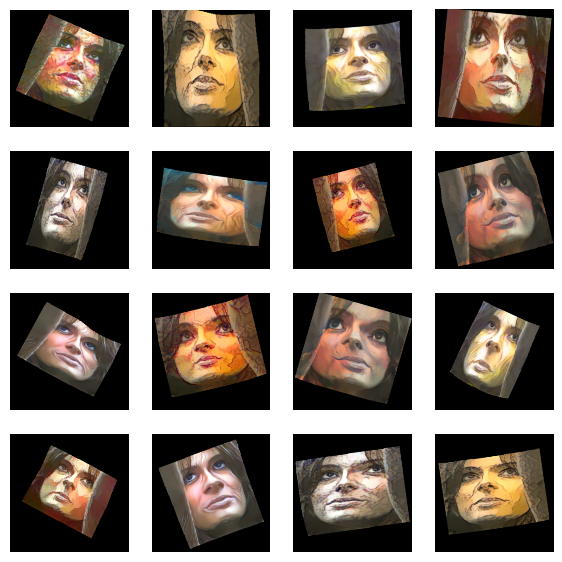

In [126]:
plt.figure(figsize=[10,10])
num_augs=9
ns_inds = np.arange(num_augs)

for i in range(16):
    if i % num_augs == 0:
        np.random.shuffle(ns_inds)
        print ns_inds
    img_list = load_menpo_image_list(
    img_dir=img_dir, train_crop_dir=train_crop_dir, img_dir_ns=img_dir_ns, mode=mode, bb_dictionary=bb_dictionary,
    image_size=image_size, margin=margin, bb_type=bb_type, augment_basic=augment_basic, augment_texture=augment_texture, p_texture=1.,
    augment_geom=augment_geom, p_geom=1.,ns_ind=ns_inds[i % num_augs])

    plt.subplot(4,4,i +1)
    img_list[0].view()
# plt.savefig('g.png',bbox='tight')

In [4]:
outdir = os.path.join('/Users/arik/Desktop/test_art_data3')
if not os.path.exists(outdir):
    os.mkdir(outdir)
    
aug_geom_dir = os.path.join(outdir,'aug_geom')
aug_texture_dir = os.path.join(outdir,'aug_texture')
aug_geom_texture_dir = os.path.join(outdir,'aug_geom_texture')
aug_basic_dir = os.path.join(outdir,'aug_basic')


if not os.path.exists(aug_texture_dir):
    os.mkdir(aug_texture_dir)
if not os.path.exists(aug_geom_dir):
    os.mkdir(aug_geom_dir)
if not os.path.exists(aug_geom_texture_dir):
    os.mkdir(aug_geom_texture_dir)
if not os.path.exists(aug_basic_dir):
    os.mkdir(aug_basic_dir)

In [11]:
num_train_images = 3148.
train_iter=100000
batch_size = 6
num_epochs = int(np.ceil((1. * train_iter) / (1. * num_train_images / batch_size)))+1

num_augs=9
num_epochs = 10
debug_data_size =5
debug=True

aug_geom = True
aug_texture = True

In [12]:
np.random.seed(1234)
ns_inds = np.arange(num_augs)
if not aug_geom and aug_texture:
    save_aug_path = aug_texture_dir
elif aug_geom and not aug_texture:
    save_aug_path = aug_geom_dir
elif aug_geom and aug_texture:
    save_aug_path = aug_geom_texture_dir
else:
    save_aug_path = aug_basic_dir
print ('saving augmented images: aug_geom='+str(aug_geom)+' aug_texture='+str(aug_texture)+' : '+str(save_aug_path))

for i in range(num_epochs):
    print ('saving augmented images of epoch %d/%d'%(i+1,num_epochs))
    if not os.path.exists(os.path.join(save_aug_path,str(i))):
        os.mkdir(os.path.join(save_aug_path,str(i)))
    
    if i % num_augs == 0:
        np.random.shuffle(ns_inds)    
    
    if not aug_geom and aug_texture:    
        img_list = load_menpo_image_list_no_geom(
        img_dir=img_dir, train_crop_dir=train_crop_dir, img_dir_ns=img_dir_ns, mode=mode, bb_dictionary=bb_dictionary,
        image_size=image_size, margin=margin, bb_type=bb_type, augment_basic=augment_basic, augment_texture=augment_texture, p_texture=1.,
        augment_geom=augment_geom, p_geom=1.,ns_ind=ns_inds[i % num_augs])
    elif aug_geom and not aug_texture:        
        img_list = load_menpo_image_list_no_texture(
        img_dir=img_dir, train_crop_dir=train_crop_dir, img_dir_ns=img_dir_ns, mode=mode, bb_dictionary=bb_dictionary,
        image_size=image_size, margin=margin, bb_type=bb_type, augment_basic=augment_basic, augment_texture=augment_texture, p_texture=1.,
        augment_geom=augment_geom, p_geom=1.,ns_ind=ns_inds[i % num_augs])
    elif aug_geom and aug_texture:        
        img_list = load_menpo_image_list(
        img_dir=img_dir, train_crop_dir=train_crop_dir, img_dir_ns=img_dir_ns, mode=mode, bb_dictionary=bb_dictionary,
        image_size=image_size, margin=margin, bb_type=bb_type, augment_basic=augment_basic, augment_texture=augment_texture, p_texture=1.,
        augment_geom=augment_geom, p_geom=1.,ns_ind=ns_inds[i % num_augs])
    else:        
        img_list = load_menpo_image_list_no_artistic(
        img_dir=img_dir, train_crop_dir=train_crop_dir, img_dir_ns=img_dir_ns, mode=mode, bb_dictionary=bb_dictionary,
        image_size=image_size, margin=margin, bb_type=bb_type, augment_basic=augment_basic, augment_texture=augment_texture, p_texture=1.,
        augment_geom=augment_geom, p_geom=1.,ns_ind=ns_inds[i % num_augs])
    
    if debug:
        img_list=img_list[:debug_data_size]
    
    for im in img_list:
        if im.pixels.shape[0] == 1:
            im_pixels = gray2rgb(np.squeeze(im.pixels))
        else:
            im_pixels = np.rollaxis(im.pixels,0,3)
        imsave( os.path.join(os.path.join(save_aug_path,str(i)),im.path.name.split('.')[0]+'.png'),im_pixels)
        mio.export_landmark_file(im.landmarks['PTS'],os.path.join(os.path.join(save_aug_path,str(i)),im.path.name.split('.')[0]+'.pts'),overwrite=True)
    

saving augmented images: aug_geom=True aug_texture=True : /Users/arik/Desktop/test_art_data3/aug_geom_texture
saving augmented images of epoch 1/10
saving augmented images of epoch 2/10
saving augmented images of epoch 3/10
saving augmented images of epoch 4/10
saving augmented images of epoch 5/10
saving augmented images of epoch 6/10
saving augmented images of epoch 7/10
saving augmented images of epoch 8/10
saving augmented images of epoch 9/10
saving augmented images of epoch 10/10
